# **Exploratory Data Analysis**

In this notebook, we will explore the nature of our data, first by using the skin cancer dataset from kaggle.

In [1]:
%matplotlib inline

import kaggle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
from pathlib import Path
from glob import glob
import seaborn as sns

from PIL import Image

np.random.seed(123)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

import itertools

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
# !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p ../data/raw --unzip -o -q

## **Step 2: Making Dictionary of images and labels**

In [3]:
BASE_SKIN_DIR = Path( "../data/raw/HAM10000_images" )
imageid_path_dict = { os.path.splitext( os.path.basename( f ) )[ 0 ] : f
                     for f in list( BASE_SKIN_DIR.rglob( "*.jpg" ) ) }

skin_lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

## **Step 3: Reading and Processing the Data**

In [4]:
skin_df = pd.read_csv( "../data/raw/HAM10000_metadata.csv" )

skin_df[ 'path' ] = skin_df[ 'image_id' ].map( imageid_path_dict.get )
skin_df[ 'cell_type' ] = skin_df[ 'dx' ].map( skin_lesion_type_dict.get )
skin_df[ 'cell_type_idx' ] = pd.Categorical( skin_df[ 'cell_type' ] ).codes

In [5]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,..\data\raw\HAM10000_images\ISIC_0031633.jpg,Benign keratosis-like lesions,2


## **Step 4: Data Cleansing**

In [6]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [7]:
print( skin_df[ 'age' ].mean(), skin_df[ 'age' ].median(), skin_df[ 'age' ].mode() )

51.863828077927295 50.0 0    45.0
Name: age, dtype: float64


[Text(0.5, 1.0, 'Stacked Histogram of Age Distribution by Sex'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count')]

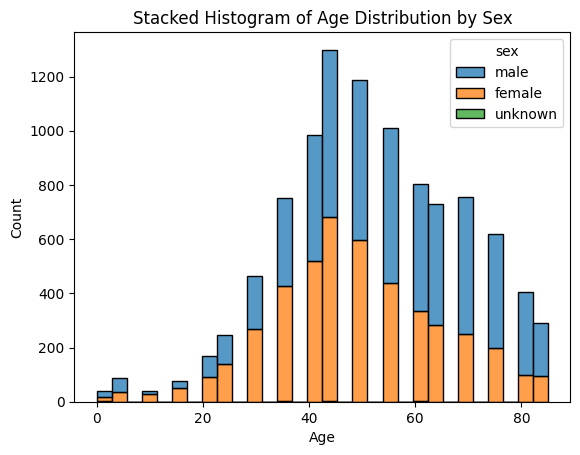

In [8]:
ax = sns.histplot( data=skin_df, 
             x='age', 
             hue='sex', 
             multiple='stack', 
             bins=30 )

ax.set( title='Stacked Histogram of Age Distribution by Sex',
       xlabel='Age', ylabel='Count' )

[Text(0.5, 1.0, 'Stacked Histogram of Age Distribution by dx'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count')]

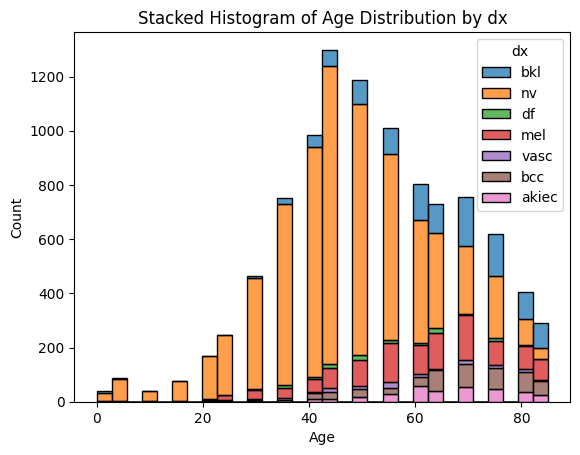

In [9]:
ax = sns.histplot( data=skin_df, 
             x='age', 
             hue='dx', 
             multiple='stack', 
             bins=30 )

ax.set( title='Stacked Histogram of Age Distribution by dx',
       xlabel='Age', ylabel='Count' )

We are going to impute by grouped mean of each sex and each dx.

In [10]:
test_impute_df = skin_df.copy()

sex = list( test_impute_df.sex.unique() )
dx = list( test_impute_df.dx.unique() )
dx_type = list( test_impute_df.dx_type.unique() )


test_impute_df[ 'age' ] = test_impute_df.groupby( [ 'sex', 'dx', 'dx_type' ] )[ 'age' ].transform( lambda x: x.fillna( round( x.mean( numeric_only = True ), 0 ) ) )
if test_impute_df.age.isnull().sum() > 0:
    test_impute_df[ 'age' ] = test_impute_df.groupby( [ 'sex', 'dx' ] )[ 'age' ].transform( lambda x: x.fillna( x.mean( numeric_only = True ) ) )
if test_impute_df.age.isnull().sum() > 0:
    test_impute_df[ 'age' ] = test_impute_df[ 'age' ].fillna( round( test_impute_df[ 'age' ].mean( numeric_only = True ), 0 ) )

print( test_impute_df[ 'age' ].isnull().sum() )

0


[Text(0.5, 1.0, 'Stacked Histogram of Age Distribution by Sex'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count')]

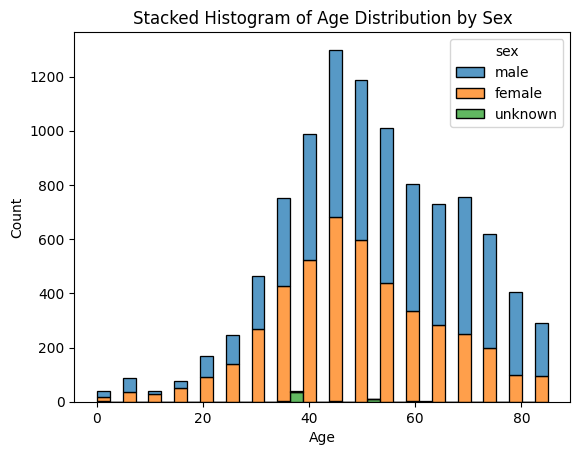

In [11]:
ax = sns.histplot( data=test_impute_df, 
             x='age', 
             hue='sex', 
             multiple='stack', 
             bins=35 )

ax.set( title='Stacked Histogram of Age Distribution by Sex',
       xlabel='Age', ylabel='Count' )

[Text(0.5, 1.0, 'Stacked Histogram of Age Distribution by dx'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count')]

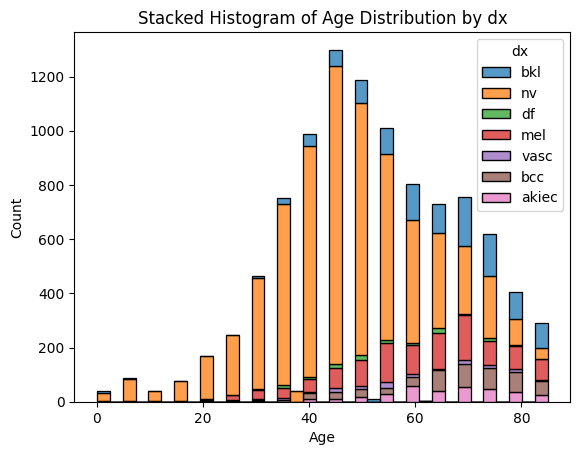

In [12]:
ax = sns.histplot( data=test_impute_df, 
             x='age', 
             hue='dx', 
             multiple='stack', 
             bins=35 )

ax.set( title='Stacked Histogram of Age Distribution by dx',
       xlabel='Age', ylabel='Count' )

First, we are going to devide the dataset by sex into male and female. Then, we will devided each gender by age ranges 
1. age < 18
2. 18 <= age < 30
3. 30 <= age < 70
4. age >= 70

In [ ]:
# Male Patients
male_df = skin_df[ skin_df[ 'sex' ] == 'male' ].copy()

age_g1 = male_df[ male_df[ 'age' ] < 18 ]
age_g2 = male_df[ ( male_df[ 'age' ] >= 18 ) & ( male_df[ 'age' ] < 30 ) ]
age_g3 = male_df[ ( male_df[ 'age' ] >= 30 ) & ( male_df[ 'age' ] < 70 ) ]
age_g4 = male_df[ male_df[ 'age' ] >= 70 ]